# ECSE-551 Mini Project 3
Authors:
* Ashley Meagher (260822930)
* Charles Sirois (261158513)  
* Emma Friesen (260886914)

In [ ]:
# Install required packages
%pip install neptune
%pip install tdqm
%pip install torchinfo


In [4]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

import pandas as pd
from pathlib import Path
from typing import Tuple, List

import torch
import torch.nn as nn
import itertools
import neptune

torch.backends.cudnn.enabled = False

from pathlib import Path
folder_path = Path('drive/MyDrive/Colab Notebooks/ECSE 551_MP3')

from google.colab import drive
from google.colab import data_table

drive.mount('/content/drive')
import sys
sys.path.insert(0, folder_path.as_posix())

# My functions
from data_loader import create_dataloaders
from model import get_model, get_optimizer, get_loss_fn, log_model_info
from training import train_model, predict
import utils
from params import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DEVICE: cuda


## Dataset

Creating datasets with:
	-img_size: 64
	-train_batch_size: 256
Creating dataloaders...
--- Full Train dataset ---
Information about the dataset:
	Number of samples: 60000
	Feature space: torch.Size([1, 64, 64])
	Different classes: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]. Their proportion: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]

--- Train dataset ---
Information about the dataset:
	Number of samples: 48000
	Feature space: torch.Size([1, 64, 64])
	Different classes: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]. Their proportion: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]

--- Val dataset ---
Information about the dataset:
	Number of samples: 12000
	Feature space: torch.Size([1, 64, 64])
	Different classes: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]. Their proportion: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


--- Test dataset ---
Information about the dataset:
	Number of samples: 10000
	Feature space: torch.Size([64, 64])



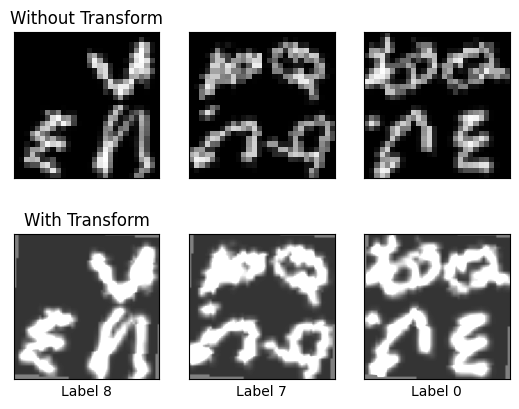

In [5]:
train_dl, val_dl, _, full_train_dl = create_dataloaders(64, 256, 256, print_ds_infos=True, project_path=folder_path)

## Training
To train models for a given set of hyperparameters. Log experiments results to Neptune.ai. See [here](https://app.neptune.ai/o/MyResearch/org/ECSE551-MP3/runs/table?viewId=9acae94a-d82e-443a-bd2f-f78600c7d59c) for the project's dashboard.

In [9]:
# Functions
def train_all_models(hyperparameters_options):
    '''
    To train a model for all the set of parameters specified
    '''
    print(f'Training all models')

    # Create list with all options
    keys, values = zip(*hyperparameters_options.items())
    hp_options_list = [dict(zip(keys, v)) for v in itertools.product(*values)]

    for idx, each_hp_set in enumerate(hp_options_list):
        print(f'\n\n-------------------- Model {idx+1}/{len(hp_options_list)} --------------------')
        print('Hyperparameters:')
        print(each_hp_set)

        start_model_training(each_hp_set)


def start_model_training(hyperparameters: dict):
    """To train a model with the given hyperparameters. Required fields:
        - seed

        - img_size
        - train_batch_size
        - test_batch_size

        - model_name
        - act_fn
        - dropout_prob

        - optimizer
        - n_epoch
        - lr
        - momentum

        - loss_fn

    Args:
        hyperparameters (dict): _description_
    """
    print(f"------- Model -------")
    # --- Hyperparameters ---
    train_batch_size = hyperparameters['train_batch_size']
    test_batch_size = hyperparameters['test_batch_size']
    img_size = hyperparameters['img_size']

    # Model
    model_name = hyperparameters['model_name']

    act_fn = hyperparameters['act_fn']
    dropout_prob = hyperparameters['dropout_prob']

    # Optim
    n_epochs = hyperparameters['n_epoch']
    optimizer_type = hyperparameters['optimizer']
    lr = hyperparameters['lr']
    momentum = hyperparameters['momentum']

    # Loss
    loss_fn = hyperparameters['loss_fn']

    # --- Setup Run ---
    run_name = utils.generate_run_name(model_name)
    print(f"Model: {model_name}\t Neptune run: {run_name}")
    run = neptune.init_run(
        project="MyResearch/ECSE551-MP3",
        api_token=NEPTUNE_API,
        custom_run_id=run_name,
        source_files=["MP3/*.py"],
    )

    # Log hyperparameters
    run["parameters"] = hyperparameters

    # ---- Load Data ---
    train_dl, val_dl, _, full_train_dl = create_dataloaders(
        img_size, train_batch_size, test_batch_size, print_ds_infos=False, neptune_run=run, project_path=folder_path
    )

    # --- Train Model ---
    model = get_model(
        model_type=model_name, act_fn=act_fn, dropout_prob=dropout_prob, img_size=img_size
    )
    log_model_info(model, img_size, run)

    optimizer = get_optimizer(model, type=optimizer_type, lr=lr, momentum=momentum)

    loss_fn = get_loss_fn(loss_fn)

    results = train_model(model, train_dl, val_dl, optimizer, loss_fn, n_epochs, run)

    run.stop()

    # utils.plot_training_loss(results)
    # utils.plot_training_acc(results)


def load_run(
    run_id: str, retrain: bool
) -> Tuple[nn.Module, List[torch.utils.data.DataLoader]]:  # (model, [full_train_dl , test_dl])
    """Load all the info from a previous run. If the model is not to be retrained, load the models'
    weights and optimizer state (TODO)

    Args:
        run_id (str): _description_
        retrain (bool): If the model is to be retrained from 0 on the full dataset (train+val)

    Returns:
        Tuple[nn.Module, List[torch.utils.data.DataLoader]]: _description_
    """
    # --- Load data ---
    print(f"Loading run from Neptune: {run_id}")

    run = neptune.init_run(
        project="MyResearch/ECSE551-MP3", with_id=run_id, api_token=NEPTUNE_API, mode="read-only"
    )

    model_id = run["sys/custom_run_id"].fetch()
    model_params = run["parameters"].fetch()
    model_type = model_id.split('_')[0]

    # --- Hyperparameters ---
    # Datasets
    train_batch_size = model_params["train_batch_size"]
    test_batch_size = model_params["test_batch_size"]
    img_size = model_params["img_size"]

    # Model
    act_fn = model_params["act_fn"]
    dropout_prob = model_params["dropout_prob"]

    # Optim
    n_epochs = model_params["n_epoch"]
    optimizer_type = model_params["optimizer"]
    lr = model_params["lr"]
    momentum = model_params["momentum"]

    # Loss
    loss_fn = model_params["loss_fn"]

    # --- Model ---
    model = get_model(
        model_type=model_type, act_fn=act_fn, dropout_prob=dropout_prob, img_size=img_size
    )
    if not retrain:
        weights_path = Path("MP3/models") / model_id / "model.pth"
        model.load_state_dict(torch.load(weights_path))

    # --- Optim ---
    optimizer = get_optimizer(model, type=optimizer_type, lr=lr, momentum=momentum)
    if not retrain:
        # Load the optimizer state
        optim_path = Path("MP3/models") / model_id / "optimizer.pth"
        optimizer.load_state_dict(torch.load(optim_path))

    # --- Loss ---
    loss_fn = get_loss_fn(loss_fn)

    # --- Datasets ---
    train_dl, val_dl, test_dl, full_train_dl = create_dataloaders(
        img_size, train_batch_size, test_batch_size, print_ds_infos=False, neptune_run=None, project_path=folder_path
    )

    run.stop()
    print('Done loading')

    return (
        model_id,
        model,
        [train_dl, full_train_dl, val_dl, test_dl],
        optimizer,
        loss_fn,
        n_epochs,
        model_params,
    )


def test_model(run_id, n_test_epochs, retrain=True):
    (
        model_id,
        model,
        (train_dl, full_train_dl, val_dl, test_dl),
        optimizer,
        loss_fn,
        n_train_epochs,
        hyperparams,
    ) = load_run(run_id, retrain=retrain)

    if retrain:
        model_id += f'_Test_{n_test_epochs}'
        print(f'Starting new training: {model_id}')
        train_run = neptune.init_run(
            project="MyResearch/ECSE551-MP3",
            api_token=NEPTUNE_API,
            custom_run_id=model_id,
            source_files=["MP3/*.py"],
        )
        hyperparams['n_epoch'] = n_test_epochs
        train_run["parameters"] = hyperparams
        train_model(model, full_train_dl, val_dl, optimizer, loss_fn, n_test_epochs, train_run)
        train_run.stop()

    y_test = predict(model, test_dl)

    pred_df = pd.DataFrame(y_test, columns=['class'])
    pred_df.index.name = 'id'
    pred_save_path = folder_path / Path('predictions') / f'{model_id}.csv'
    pred_df.to_csv(pred_save_path)
    print(f'Predictions saved to {pred_save_path}')


In [7]:
# Definition of experiments
LR_EXP_HP_OPTIONS = {
    "seed": [SEED],
    # Dataset
    "img_size": [32],
    "train_batch_size": [64],
    "test_batch_size": [64],
    # Model
    "model_name": ["LeNet5"],  # "MyNet", "LeNet5", "VGG11", "VGG13", "VGG16"
    "act_fn": ["ReLu"],
    "dropout_prob": [0.15],
    # Optim
    "optimizer": ["Adam"],
    "n_epoch": [100],
    "lr": [0.01, 1e-3, 1e-4, 1e-5],
    "momentum": [0.5],
    # Loss
    "loss_fn": ["cross_entropy"],  # 'cross_entropy', 'nll'
}

BATCH_SIZE_EXP_HP_OPTIONS = {
    "seed": [SEED],
    # Dataset
    "img_size": [32],
    "train_batch_size": [32, 64, 128, 256, 512],
    "test_batch_size": [64],
    # Model
    "model_name": ["LeNet5"],  # "MyNet", "LeNet5", "VGG11", "VGG13", "VGG16"
    "act_fn": ["ReLu"],
    "dropout_prob": [0.15],
    # Optim
    "optimizer": ["Adam"],
    "n_epoch": [10],
    "lr": [1e-3],
    "momentum": [0.5],
    # Loss
    "loss_fn": ["cross_entropy"],  # 'cross_entropy', 'nll'
}

ACT_FN_EXP_HP_OPTIONS = {
    "seed": [SEED],
    # Dataset
    "img_size": [32],
    "train_batch_size": [128],
    "test_batch_size": [128],
    # Model
    "model_name": ["LeNet5"],  # "MyNet", "LeNet5", "VGG11", "VGG13", "VGG16"
    "act_fn": ["ReLu", "Tanh", "LeakyReLU", 'Sigmoid'],
    "dropout_prob": [0.15],
    # Optim
    "optimizer": ["Adam"],
    "n_epoch": [10],
    "lr": [1e-3],
    "momentum": [0.5],
    # Loss
    "loss_fn": ["cross_entropy"],  # 'cross_entropy', 'nll'
}

LOSS_EXP_HP_OPTIONS = {
    "seed": [SEED],
    # Dataset
    "img_size": [32],
    "train_batch_size": [128],
    "test_batch_size": [128],
    # Model
    "model_name": ["LeNet5"],  # "MyNet", "LeNet5", "VGG11", "VGG13", "VGG16"
    "act_fn": ["ReLu"],
    "dropout_prob": [0.15],
    # Optim
    "optimizer": ["Adam"],
    "n_epoch": [10],
    "lr": [1e-3],
    "momentum": [0.5],
    # Loss
    "loss_fn": ["cross_entropy", 'nll'],  # 'cross_entropy', 'nll'
}

BEST_MODEL_EXP = {
    "seed": [SEED],
    # Dataset
    "img_size": [32, 64],
    "train_batch_size": [256],
    "test_batch_size": [256],
    # Model
    "model_name": ["VGG13", "VGG16"],  # "MyNet", "LeNet5", "VGG11", "VGG13", "VGG16"
    "act_fn": ["LeakyReLU"],
    "dropout_prob": [0, 0.1, 0.15, 0.2],
    # Optim
    "optimizer": ["Adam"],
    "n_epoch": [25],
    "lr": [1e-3],
    "momentum": [0],
    # Loss
    "loss_fn": ["cross_entropy"],  # 'cross_entropy', 'nll'
}

TEST_EXP = {
    "seed": [SEED],
    # Dataset
    "img_size": [32],
    "train_batch_size": [256],
    "test_batch_size": [256],
    # Model
    "model_name": ["LeNet5"],  # "MyNet", "LeNet5", "VGG11", "VGG13", "VGG16"
    "act_fn": ["LeakyReLU"],
    "dropout_prob": [0.15],
    # Optim
    "optimizer": ["Adam"],
    "n_epoch": [3],
    "lr": [1e-3],
    "momentum": [0],
    # Loss
    "loss_fn": ["cross_entropy"],  # 'cross_entropy', 'nll'
}


Training all models


-------------------- Model 1/1 --------------------
Hyperparameters:
{'seed': 1, 'img_size': 32, 'train_batch_size': 256, 'test_batch_size': 256, 'model_name': 'LeNet5', 'act_fn': 'LeakyReLU', 'dropout_prob': 0.15, 'optimizer': 'Adam', 'n_epoch': 3, 'lr': 0.001, 'momentum': 0, 'loss_fn': 'cross_entropy'}
------- Model -------
Model: LeNet5	 Neptune run: LeNet5_231212_1825
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-129
Creating datasets with:
	-img_size: 32
	-train_batch_size: 256
Creating dataloaders...
Loading model... LeNet5
Validation set: Avg. Loss: 2.3050     Avg. Acc: 10.01%

####### Epoch 1/3 #######


  0%|          | 0/188 [00:00<?, ?it/s]

Validation set: Avg. Loss: 1.7448     Avg. Acc: 37.41%

####### Epoch 2/3 #######


  0%|          | 0/188 [00:00<?, ?it/s]

Validation set: Avg. Loss: 1.5069     Avg. Acc: 46.80%

####### Epoch 3/3 #######


  0%|          | 0/188 [00:00<?, ?it/s]

Validation set: Avg. Loss: 1.4153     Avg. Acc: 50.64%

-----------------------------
Final val acc: 50.64%
-----------------------------
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-129/metadata


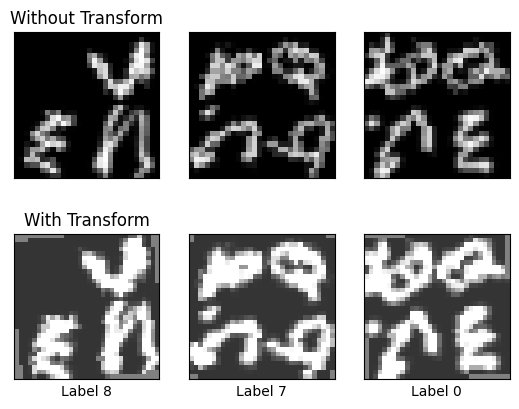

In [8]:
# Train the model for a given experiment
hyperparameters_options = TEST_EXP  # set this to the desired experiment
train_all_models(hyperparameters_options)

## Prediction
Will load the model of a given neptune run id and retrain it on the train+val datasets for the given number of epochs

Loading run from Neptune: MP3-129
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-129
Loading model... LeNet5
Creating datasets with:
	-img_size: 32
	-train_batch_size: 256
Creating dataloaders...
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-129/metadata
Done loading
Starting new training: LeNet5_231212_1825_Test_3
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-131
Validation set: Avg. Loss: 2.3050     Avg. Acc: 10.00%

####### Epoch 1/3 #######


  0%|          | 0/235 [00:00<?, ?it/s]

Validation set: Avg. Loss: 1.7117     Avg. Acc: 38.90%

####### Epoch 2/3 #######


  0%|          | 0/235 [00:00<?, ?it/s]

Validation set: Avg. Loss: 1.4493     Avg. Acc: 49.30%

####### Epoch 3/3 #######


  0%|          | 0/235 [00:00<?, ?it/s]

Validation set: Avg. Loss: 1.3358     Avg. Acc: 53.50%

-----------------------------
Final val acc: 53.50%
-----------------------------
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
All 3 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-131/metadata
Predictions saved to drive/MyDrive/Colab Notebooks/ECSE 551_MP3/predictions/LeNet5_231212_1825_Test_3.csv


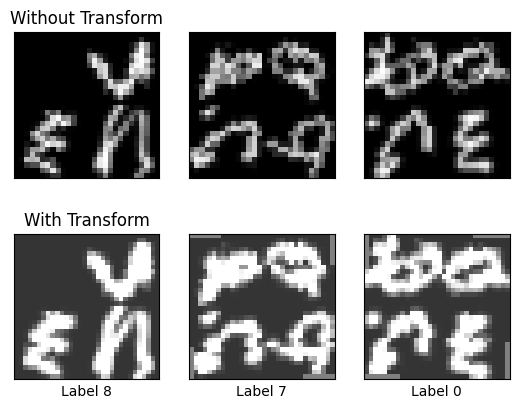

In [12]:
run_id = "MP3-129"
n_epochs = 3
test_model(run_id, n_epochs)

## Results
To plot the results of the various experiments. Loads the data from the neptune board.


----- Learning rate -----
Loading run from Neptune: MP3-91
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-91
Loading run from Neptune: MP3-86
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-86
Loading run from Neptune: MP3-87
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-87
Loading run from Neptune: MP3-88
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-88


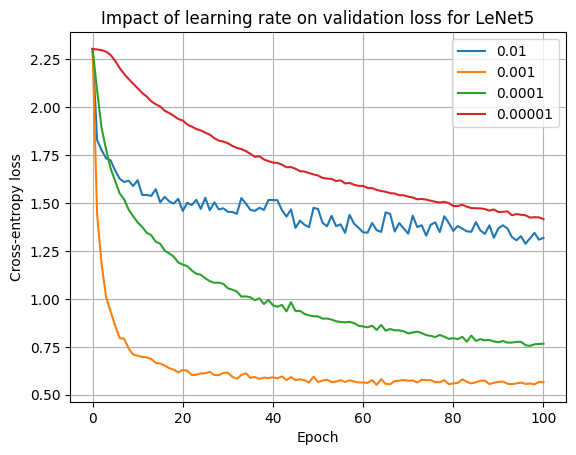


----- Batch sizes -----
Loading run from Neptune: MP3-93
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-93
Loading run from Neptune: MP3-94
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-94
Loading run from Neptune: MP3-95
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-95
Loading run from Neptune: MP3-96
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-96
Loading run from Neptune: MP3-97
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-97


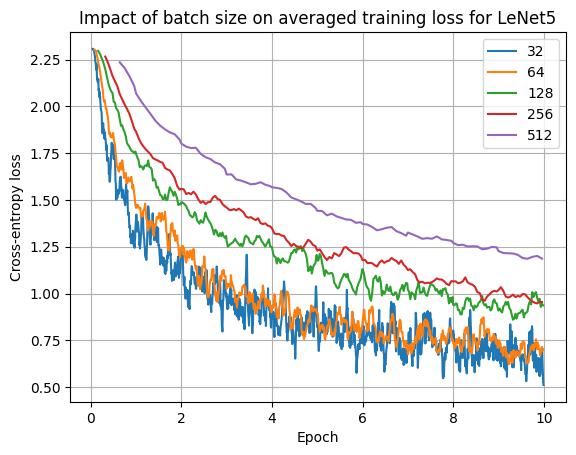


----- Act FN -----
Loading run from Neptune: MP3-98
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-98
Loading run from Neptune: MP3-99
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-99
Loading run from Neptune: MP3-100
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-100
Loading run from Neptune: MP3-101
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-101


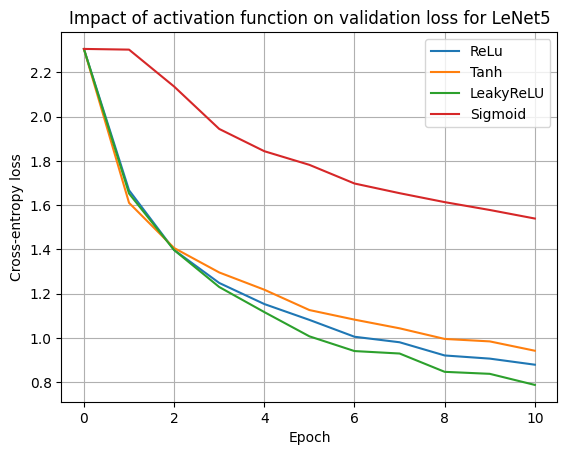


----- Loss -----
Loading run from Neptune: MP3-102
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-102
Loading run from Neptune: MP3-103
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-103


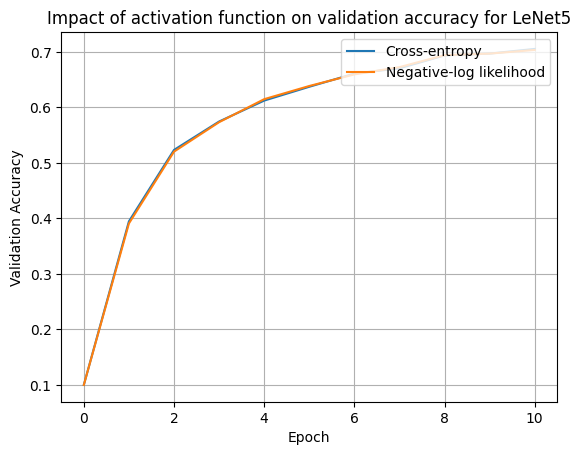


----- Best model -----
Loading run from Neptune: MP3-109
https://app.neptune.ai/MyResearch/ECSE551-MP3/e/MP3-109


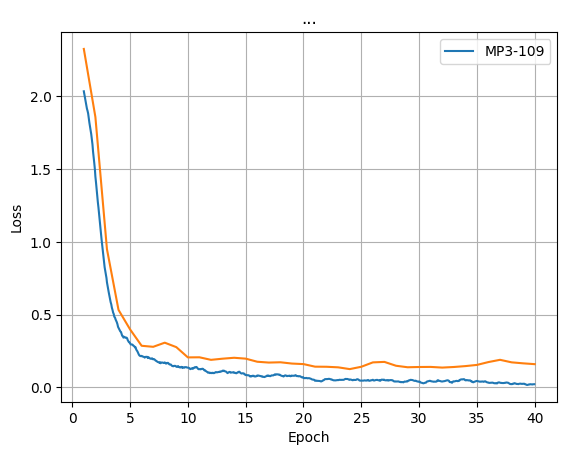

In [13]:
import plot_results

plot_results.lenet5_lr_plots()

plot_results.lenet5_batch_size_plots()

plot_results.lenet5_act_fn_plots()

plot_results.lenet5_loss_plots()

plot_results.plot_best_model()